In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Directory containing the dataset files
dataset_dir = 'D:\Internship - Deep Learning-based Cryptanalysis of Lightweight Block Ciphers\Internship - EISystems\MachineLearningCVE'

# List of dataset files
dataset_files = [
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
]

# Load and concatenate all datasets
dataframes = []
for file in dataset_files:
    file_path = os.path.join(dataset_dir, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Combine all dataframes
data = pd.concat(dataframes, ignore_index=True)

In [2]:
print(data.head())
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values
data.dropna(inplace=True)

    Destination Port   Flow Duration   Total Fwd Packets  \
0              49188               4                   2   
1              49188               1                   2   
2              49188               1                   2   
3              49188               1                   2   
4              49486               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        0                           12   
2                        0                           12   
3                        0                           12   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             0                       6   
2                             0                       6   
3                             0                 

In [3]:
label_mapping = {
    'BENIGN': 0,
    'FTP-Patator': 1,
    'SSH-Patator': 2,
    'DoS slowloris': 3,
    'DoS Slowhttptest': 4,
    'DoS Hulk': 5,
    'DoS GoldenEye': 6,
    'Heartbleed': 7,
    'Web Attack Brute Force': 8,
    'Web Attack XSS': 9,
    'Web Attack Sql Injection': 10,
    'Infiltration': 11,
    'Bot': 12,
    'PortScan': 13,
    'DDoS': 14
}

data['Label'] = data[' Label'].map(label_mapping)

# Separate features and labels
#X = data.drop(' Label', axis=1)
#y = data[' Label']

# Select specific features
selected_features = [ #' Source Port',' Bwd Packet Length Max', 
    ' Destination Port', 
    ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Flow IAT Mean', 
    ' Flow IAT Std', ' Flow IAT Min', ' Fwd IAT Min', ' Bwd Packets/s', 
    ' Min Packet Length', ' Max Packet Length', ' Init_Win_bytes_backward', 
    ' act_data_pkt_fwd'
]

X = data[selected_features]
y = data['Label']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the median of the column
median_values = X_train.median()
X_train.fillna(median_values, inplace=True)
X_test.fillna(median_values, inplace=True)

# Now apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [13]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')

# Train the model
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [14]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [15]:
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_mapping.keys())
# Print classification report
print(class_report)

                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00    454538
             FTP-Patator       1.00      1.00      1.00      1588
             SSH-Patator       1.00      1.00      1.00      1179
           DoS slowloris       0.99      1.00      0.99      1159
        DoS Slowhttptest       0.99      0.99      0.99      1100
                DoS Hulk       0.98      1.00      0.99     46025
           DoS GoldenEye       0.96      0.98      0.97      2059
              Heartbleed       1.00      1.00      1.00         2
  Web Attack Brute Force       0.78      0.74      0.76       301
          Web Attack XSS       0.34      0.45      0.39       130
Web Attack Sql Injection       0.50      0.25      0.33         4
            Infiltration       1.00      0.86      0.92         7
                     Bot       0.60      0.81      0.69       393
                PortScan       0.99      1.00      1.00     31786
         

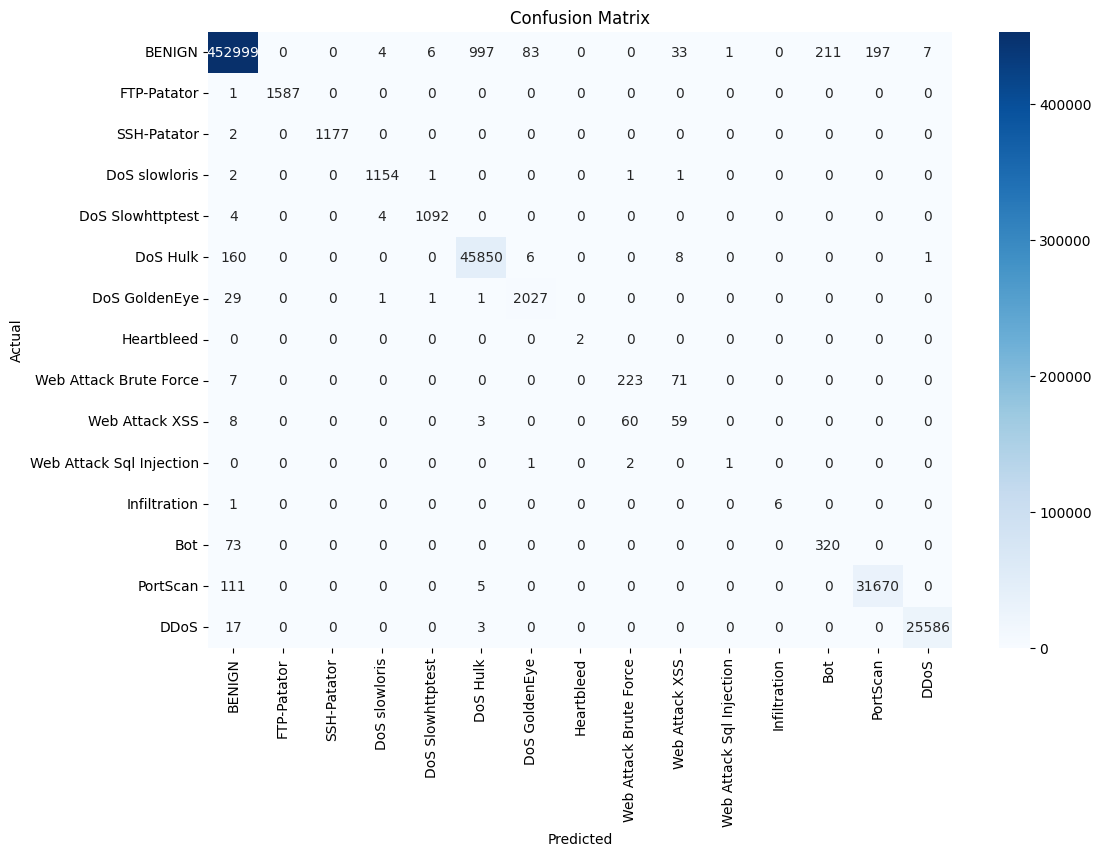

In [16]:
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
 # Save the trained model
model_filename = 'random_forest_model.pkl'
joblib.dump(model, model_filename)

print(f"Model saved as {model_filename}")

Model saved as random_forest_model.pkl


In [12]:
# Dictionary to store unique labels from each file
label_dict = {}

# Load each dataset and find unique labels
for file in dataset_files:
    file_path = os.path.join(dataset_dir, file)
    df = pd.read_csv(file_path)
    unique_labels = df[' Label'].unique()
    label_dict[file] = unique_labels

# Print the unique labels from each file
for file, labels in label_dict.items():
    print(f"Unique labels in {file}: {labels}")

Unique labels in Monday-WorkingHours.pcap_ISCX.csv: ['BENIGN']
Unique labels in Tuesday-WorkingHours.pcap_ISCX.csv: ['BENIGN' 'FTP-Patator' 'SSH-Patator']
Unique labels in Wednesday-workingHours.pcap_ISCX.csv: ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
Unique labels in Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: ['BENIGN' 'Web Attack Brute Force' 'Web Attack XSS'
 'Web Attack Sql Injection']
Unique labels in Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: ['BENIGN' 'Infiltration']
Unique labels in Friday-WorkingHours-Morning.pcap_ISCX.csv: ['BENIGN' 'Bot']
Unique labels in Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: ['BENIGN' 'PortScan']
Unique labels in Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: ['BENIGN' 'DDoS']


In [15]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model_lr.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test_scaled)

# Evaluate the model
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr, target_names=label_mapping.keys())

# Print classification report
print("Logistic Regression Classification Report")
print(class_report_lr)

# Save the model
joblib.dump(model_lr, 'logistic_regression_classifier.pkl')

c:\Users\91741\.conda\envs\ENVNAME\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\91741\.conda\envs\ENVNAME\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\91741\.conda\envs\ENVNAME\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-def

Logistic Regression Classification Report
                          precision    recall  f1-score   support

                  BENIGN       0.92      0.97      0.95    454136
             FTP-Patator       0.00      0.00      0.00      1598
             SSH-Patator       0.00      0.00      0.00      1127
           DoS slowloris       0.57      0.19      0.29      1126
        DoS Slowhttptest       0.00      0.00      0.00      1171
                DoS Hulk       0.74      0.92      0.82     46014
           DoS GoldenEye       0.62      0.12      0.20      2093
              Heartbleed       0.00      0.00      0.00         1
  Web Attack Brute Force       0.00      0.00      0.00       273
          Web Attack XSS       0.00      0.00      0.00       111
Web Attack Sql Injection       0.00      0.00      0.00         4
            Infiltration       0.00      0.00      0.00         9
                     Bot       0.00      0.00      0.00       399
                PortScan       0.

['logistic_regression_classifier.pkl']

In [ ]:
from sklearn.svm import SVC

# Initialize the model
model_svm = SVC(random_state=42)

# Train the model
model_svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = model_svm.predict(X_test_scaled)

# Evaluate the model
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm, target_names=label_mapping.keys())

# Print classification report
print("SVM Classification Report")
print(class_report_svm)

# Save the model
joblib.dump(model_svm, 'svm_classifier.pkl')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
model_knn = KNeighborsClassifier()

# Train the model
model_knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = model_knn.predict(X_test_scaled)

# Evaluate the model
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn, target_names=label_mapping.keys())

# Print classification report
print("KNN Classification Report")
print(class_report_knn)

# Save the model
joblib.dump(model_knn, 'knn_classifier.pkl')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
model_gbc = GradientBoostingClassifier(random_state=42)

# Train the model
model_gbc.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gbc = model_gbc.predict(X_test_scaled)

# Evaluate the model
conf_matrix_gbc = confusion_matrix(y_test, y_pred_gbc)
class_report_gbc = classification_report(y_test, y_pred_gbc, target_names=label_mapping.keys())

# Print classification report
print("Gradient Boosting Classification Report")
print(class_report_gbc)

# Save the model
joblib.dump(model_gbc, 'gradient_boosting_classifier.pkl')

In [ ]:
from xgboost import XGBClassifier

# Initialize the model
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model_xgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluate the model
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_mapping.keys())

# Print classification report
print("XGBoost Classification Report")
print(class_report_xgb)

# Save the model
joblib.dump(model_xgb, 'xgboost_classifier.pkl')

In [ ]:
import lightgbm as lgb

# Initialize the model
model_lgb = lgb.LGBMClassifier(random_state=42)

# Train the model
model_lgb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lgb = model_lgb.predict(X_test_scaled)

# Evaluate the model
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
class_report_lgb = classification_report(y_test, y_pred_lgb, target_names=label_mapping.keys())

# Print classification report
print("LightGBM Classification Report")
print(class_report_lgb)

# Save the model
joblib.dump(model_lgb, 'lightgbm_classifier.pkl')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the model
model_ada = AdaBoostClassifier(random_state=42)

# Train the model
model_ada.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ada = model_ada.predict(X_test_scaled)

# Evaluate the model
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
class_report_ada = classification_report(y_test, y_pred_ada, target_names=label_mapping.keys())

# Print classification report
print("AdaBoost Classification Report")
print(class_report_ada)

# Save the model
joblib.dump(model_ada, 'adaboost_classifier.pkl')

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
model_dt = DecisionTreeClassifier(random_state=42)

# Train the model
model_dt.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = model_dt.predict(X_test_scaled)

# Evaluate the model
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt, target_names=label_mapping.keys())

# Print classification report
print("Decision Tree Classification Report")
print(class_report_dt)

# Save the model
joblib.dump(model_dt, 'decision_tree_classifier.pkl')

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize the model
model_nb = GaussianNB()

# Train the model
model_nb.fit(X_train_scaled, y_train)

# Make predictions
y_pred_nb = model_nb.predict(X_test_scaled)

# Evaluate the model
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb, target_names=label_mapping.keys())

# Print classification report
print("Naive Bayes Classification Report")
print(class_report_nb)

# Save the model
joblib.dump(model_nb, 'naive_bayes_classifier.pkl')